# PHE Daily Cases

Created by Michael George (AKA Logiqx)

Website: https://logiqx.github.io/covid-stats/

## PHE Core

Import library for working with PHE data

In [164]:
import os
import csv

import numpy as np
import matplotlib.pyplot as plt

import common_core
import phe_core

## Area Class

Supports a single area - nation, region, ltla, etc

In [165]:
SOURCE_ONS = "Source: coronavirus.data.gov.uk"

GITHUB_URL = "https://logiqx.github.io/covid-stats/daily-data"

## Areas Class

Combines multiple areas - nation, region, ltla, etc

In [166]:
class Areas(common_core.Printable):

    def __init__(self, areaType):
        """Initialisise the areas object"""

        self.areaType = areaType
        self.areas = {}

    
    def addArea(self, areaName):
        """Add a new area which can then be loadeded from disk"""
        
        area = Area(self.areaType, areaName)

        self.areas[areaName] = area
        

    def loadArea(self, areaName):
        """Load PHE data for a single area"""
        
        self.areas[areaName].loadDaily()
        

    def plotCases(self):
        """Plot cases by specimen date age demographics"""
        
        # Create new figure
        plt.figure(clear=True, figsize=(16, 9))  
        
        # Plot data
        for areaName in self.areas:
            area = self.areas[areaName]

            # Get all value up to the last non-zero
            tmp_points = np.array(area.data["daily"]["cases"]["cases"])
            idx = np.max(np.nonzero(tmp_points))
            tmp_points = tmp_points[:idx+1-5]

            # Calculate moving average using convolve
            # consider mode = "same" instead of concatenate?
            y_points = np.concatenate((np.zeros(3), np.convolve(tmp_points, np.ones(7)/7, mode="valid")))
            x_points = np.arange(len(y_points))
            x_ticks = np.array(area.data["daily"]["cases"]["date"])[:idx+1]
            
            plt.plot(x_points, y_points, label = area.areaName) #, color='green', linewidth=2)

        # Set xticks
        plt.xticks(np.arange(0, len(x_ticks), step=7), x_ticks[::7], rotation=90)
        
        # Add title, axis labels and legend
        plt.title('Daily Cases Test')
        plt.ylabel('Number of cases')
        plt.legend()
     
        # Show figure
        plt.show()
        
        
    def plotAreas(self, period="daily"):
        """Plot charts for each area"""

        if self.areaType == "nation":
            for areaName in ["England"]:
                self.areas[areaName].plotData(period)

        if self.areaType == "region":
            for areaName in ["North East"]:
                self.areas[areaName].plotData(period)

## Load data into memory

In [167]:
class Area(common_core.Printable):

    def __init__(self, areaType, areaName):
        """Initialisise the area object"""

        self.data = {}

        self.areaType = areaType
        self.areaName = areaName

        self.safeName = common_core.getSafeName(areaName)
        self.csvName = self.safeName + '.csv'
        

    def load(self, period, dataType):
        """Load demographic data - cases or deaths"""

        fileName = os.path.join(common_core.dataDir, phe_core.PHE_DASHBOARD, "csv", period, dataType, self.areaType, self.csvName)
        partName = common_core.getPartName(fileName)

        try:
            with open(fileName, 'r') as f:
                reader = csv.reader(f, delimiter = ',')

                dtype = []
                converters = {}
                colNames = next(reader)

                for i in range(len(colNames)):
                    colName = colNames[i]
                    if colName == "date":
                        dtype.append((colName, "U10"))
                    elif colName == "areaName":
                        dtype.append((colName, "U40"))
                    elif colName.endswith("Rate"):
                        dtype.append((colName, "f8"))
                        converters[i] = lambda s: float(s or 0)
                    else:
                        dtype.append((colName, "u4"))
                        converters[i] = lambda s: int(s or 0)

                data = np.genfromtxt(f, dtype=dtype, converters=converters, delimiter=",")

            # Ensure period is present in data arrays
            if period not in self.data:
                self.data[period] = {}

            # Store the data
            self.data[period][dataType] = data

        # General catch all
        except:
            print(f"Failed to load {dataType} for {self.areaName}")
            raise


    def loadDaily(self):
        """Load PHE daily data"""

        period = "daily"
        
        if self.areaType != "nhsregion":
            self.load(period, "cases")
            self.load(period, "deaths")
        else:
            self.load(period, "patients")


    def plotData(self, period):
        """Plot data for cases, hospitalisations and deaths"""

        fig, axs = plt.subplots(3, figsize=(16, 18), dpi=150)

        self.plotCases(period, axs[0])
        #self.plotPatients(period, axs[1])
        self.plotDeaths(period, axs[2])

        gitHubStr = "\nA detailed explanation along with a link to the code and data " + \
                     f"that were used to create these charts can be found at {GITHUB_URL}"

        fig.text(0.5, 0.02, gitHubStr, horizontalalignment='center', verticalalignment='bottom')

        plt.subplots_adjust(hspace=0.4)
        plt.show()

        partName = os.path.join("docs", "daily-data", self.areaType, common_core.getSafeName(self.areaName) + ".png")
        fileName = os.path.join(common_core.projdir, partName)

        dirName = os.path.dirname(fileName)
        if not os.path.exists(dirName):
            os.makedirs(dirName)

        print(f"Saving {partName}...")
        fig.savefig(fileName, bbox_inches='tight', facecolor='w')
        plt.close(fig)
        

    def plotCases(self, period, ax):
        """Plot data for daily cases"""

        data = self.data[period]["cases"]
        
        for ageDemographic in phe_core.ageDemographics:
            # Get all value up to the last non-zero
            tmp_points = data["cases" + ageDemographic.replace("+", "")]
            idx = np.max(np.nonzero(tmp_points))
            tmp_points = tmp_points[:idx+1-5]

            # Calculate moving average using convolve
            # consider mode = "same" instead of concatenate?
            y_points = np.concatenate((np.zeros(3), np.convolve(tmp_points, np.ones(7)/7, mode="valid")))
            x_points = np.arange(len(y_points))
            xTickLabels = np.array(data["date"])[:idx+1]
            
            ax.plot(x_points, y_points, label=ageDemographic.replace("_", "-")) #, color='green', linewidth=2)

        # Set xticks
        tickInterval = 7
        #ax.set_xticks(np.arange(0, len(x_ticks), step=7), x_ticks[::7], rotation=90)
        ax.set_xticks(np.arange(0, len(xTickLabels), tickInterval))
    
        # Change the x-axis to shown the actual dates
        ax.set_xticklabels(xTickLabels[::tickInterval], rotation=90)
        
        # Add title, axis labels and legend
        ax.set_title('Daily Cases Test')
        ax.set_ylabel('Number of cases')

        ax.legend(loc="upper left", borderaxespad=1, fontsize="small")
        
        
    def plotDeaths(self, period, ax):
        """Plot data for daily deaths"""

        data = self.data[period]["deaths"]
        
        for ageDemographic in phe_core.ageDemographics:
            # Get all value up to the last non-zero
            tmp_points = data["deaths" + ageDemographic.replace("+", "")]
            idx = np.nonzero(tmp_points)
            if len(idx[0]) > 0:
                idx = np.max(idx)
                tmp_points = tmp_points[:idx+1-5]

                # Calculate moving average using convolve
                # consider mode = "same" instead of concatenate?
                y_points = np.concatenate((np.zeros(3), np.convolve(tmp_points, np.ones(7)/7, mode="valid")))
                x_points = np.arange(len(y_points))
                xTickLabels = np.array(data["date"])[:idx+1]

                ax.plot(x_points, y_points, label=ageDemographic.replace("_", "-")) #, color='green', linewidth=2)

        # Set xticks
        tickInterval = 7
        #ax.set_xticks(np.arange(0, len(x_ticks), step=7), x_ticks[::7], rotation=90)
        ax.set_xticks(np.arange(0, len(xTickLabels), tickInterval))
    
        # Change the x-axis to shown the actual dates
        ax.set_xticklabels(xTickLabels[::tickInterval], rotation=90)
        
        # Add title, axis labels and legend
        ax.set_title('Daily Deaths Test')
        ax.set_ylabel('Number of deaths')

        ax.legend(loc="upper left", borderaxespad=1, fontsize="small")

In [168]:
print("Loading data...")

overview = Areas(areaType="overview")
for overviewName in phe_core.overviewNames:
    overview.addArea(overviewName)
    overview.loadArea(overviewName)

nations = Areas(areaType="nation")
for nationName in phe_core.nationNames:
    nations.addArea(nationName)
    nations.loadArea(nationName)

regions = Areas(areaType="region")
for regionName in common_core.regionNames:
    regions.addArea(regionName)
    regions.loadArea(regionName)

nhsRegions = Areas(areaType="nhsregion")
for nhsRegionName in common_core.nhsRegionNames:
    nhsRegions.addArea(nhsRegionName)
    nhsRegions.loadArea(nhsRegionName)

ltlas = Areas(areaType="ltla")
for ltlaName in phe_core.ltlaNames:
    ltlas.addArea(ltlaName)
    #ltlas.loadArea(ltlaName)

# Transfer patient data from NHS regions to standard regions
for areaName in common_core.nhsRegionMappings:
    nhsAreaName = common_core.nhsRegionMappings[areaName]
    periods = nhsRegions.areas[nhsAreaName].data

    for period in periods:
        periodData = periods[period]
        for dataType in periodData:
            regions.areas[areaName].data[period][dataType] = periodData[dataType]

print("\nAll done!")

Loading data...

All done!


## Draw Charts

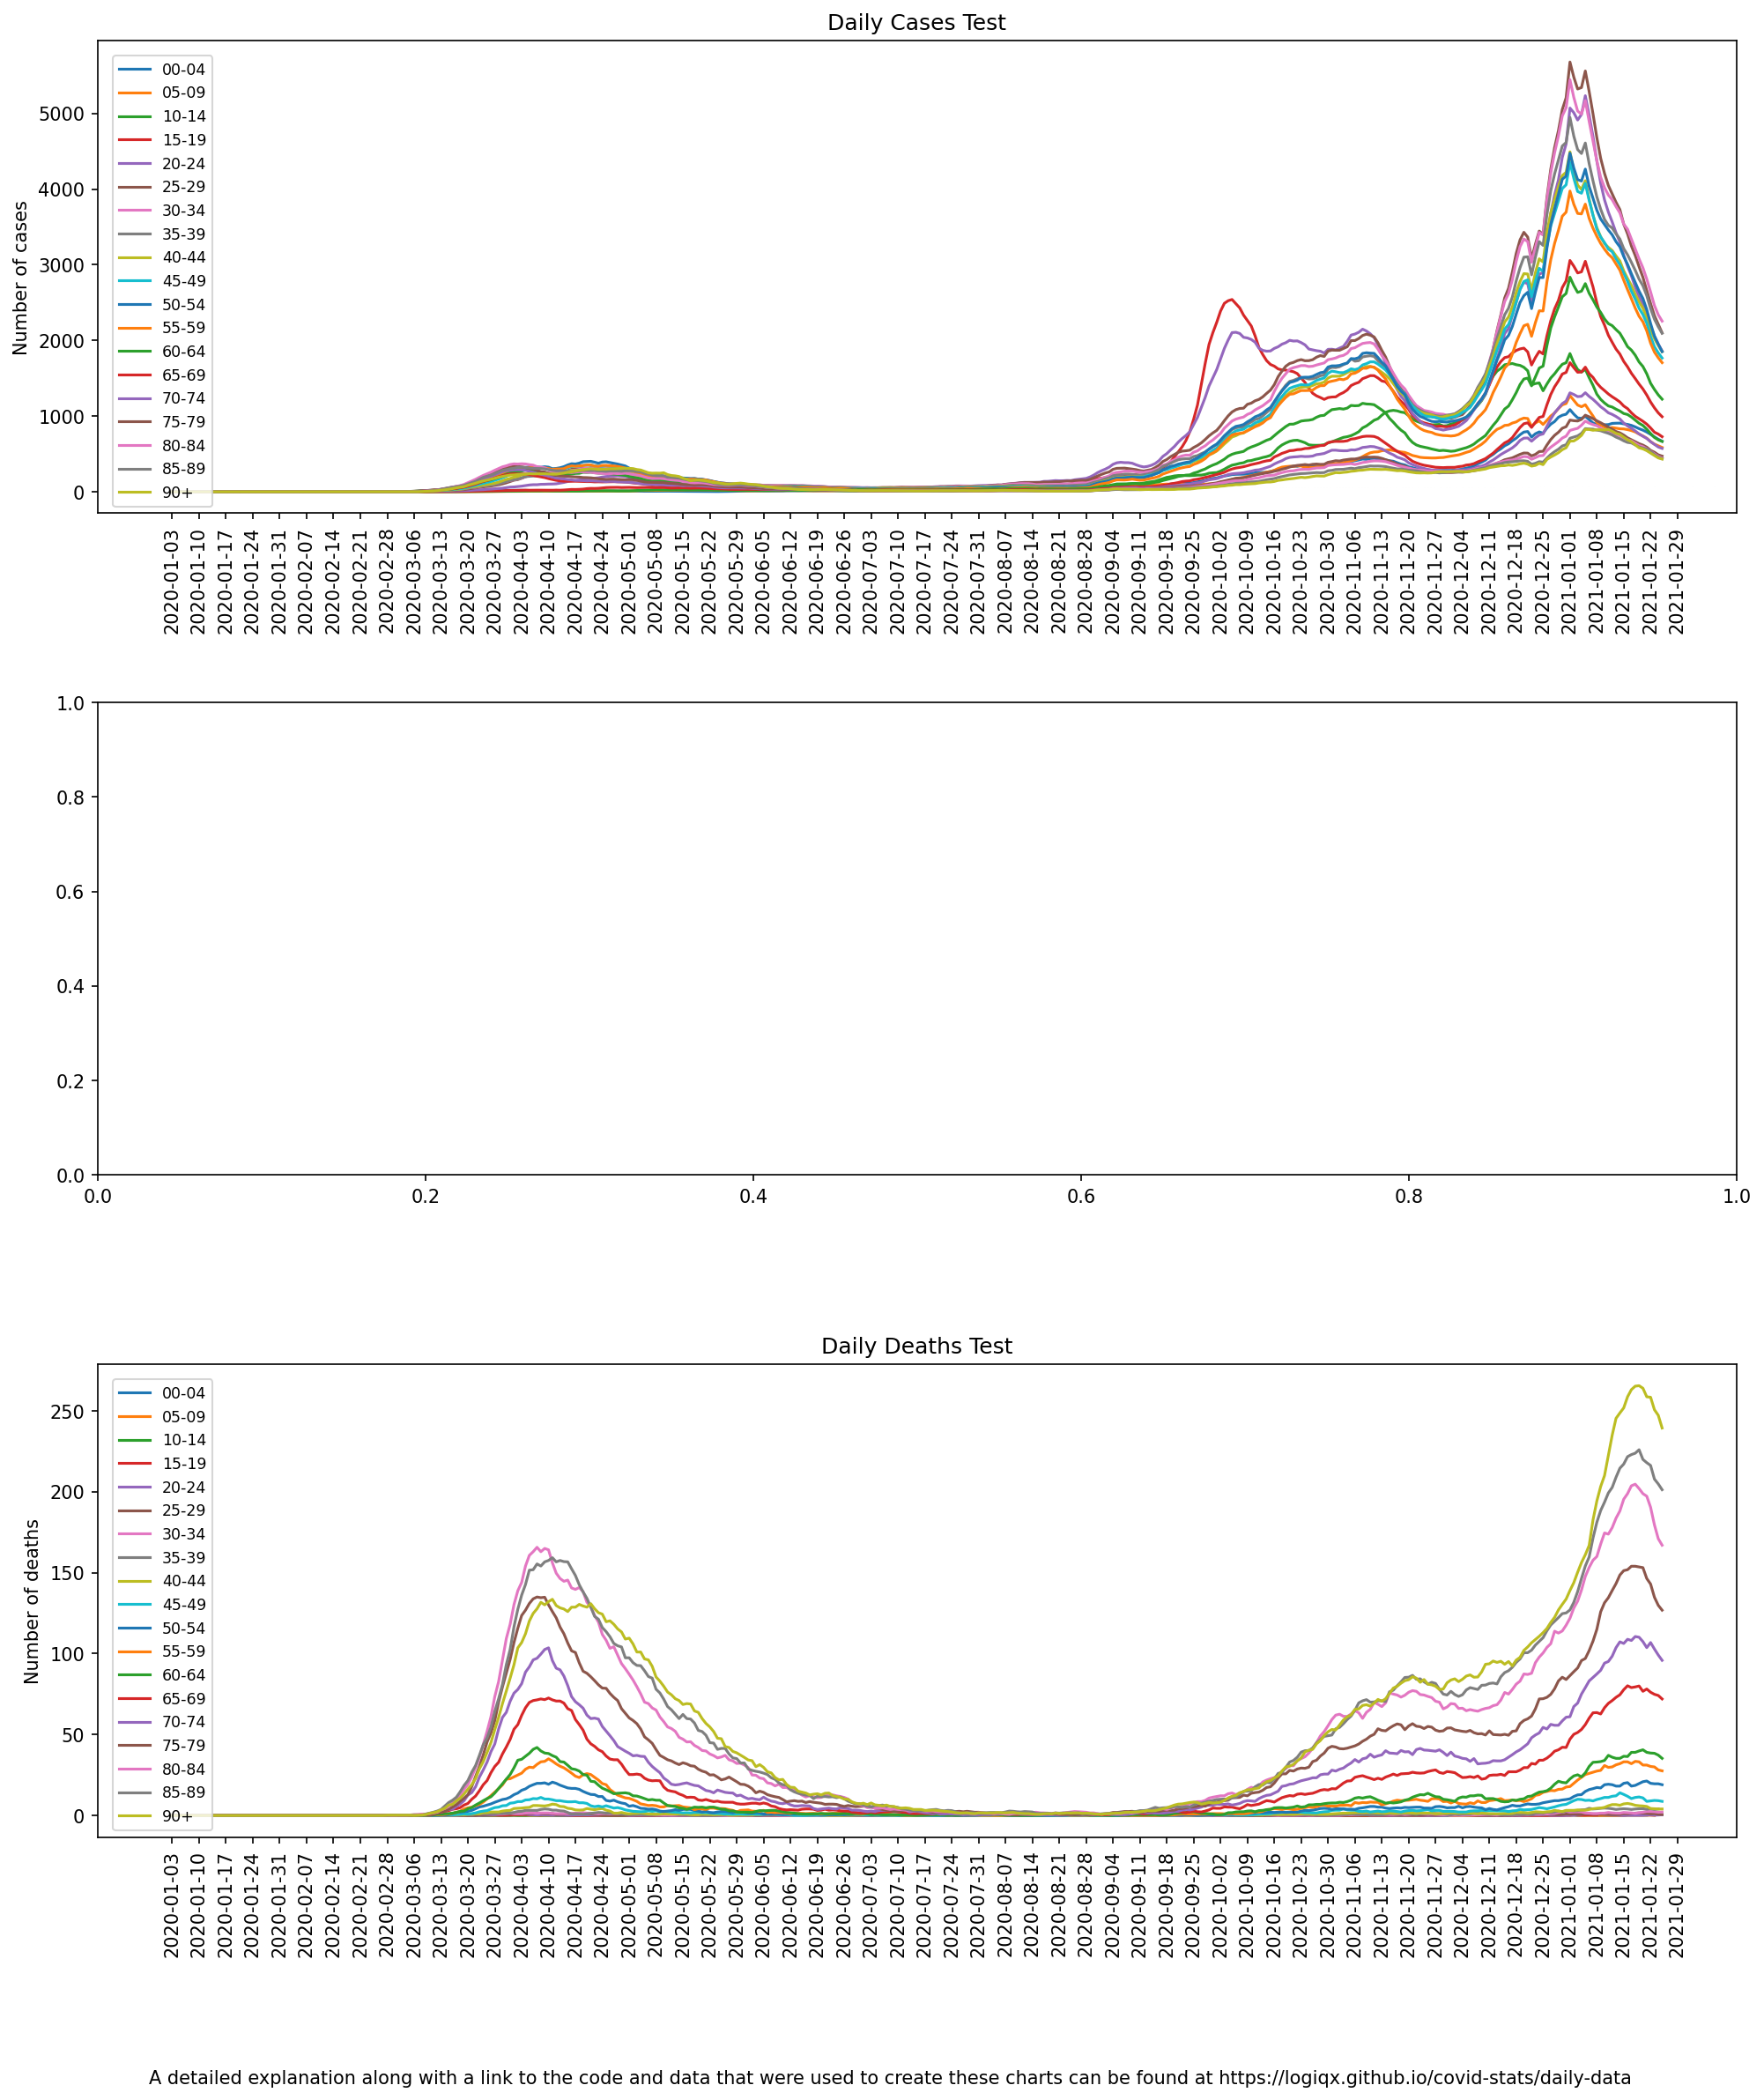

Saving docs/daily-data/nation/england.png...


In [169]:
nations.plotAreas()